# Correlation matrix of returns

We compute the **daily return correlations** among tickers and with the portfolio to understand co-movement.


In [12]:
# Imports
import os, sys, numpy as np, matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


from data.fetch_data import load_prices
from data.analytics import calculate_correlations
import pandas as pd
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Date range for fetching data
start = "2024-01-01"
end   = "2025-01-01"
tickers = ["META", "AAPL", "NFLX", "GOOGL", "AMZN"]

# Load prices (tickers must be defined; e.g., ["META","AAPL","AMZN","NFLX","GOOG"])
prices = load_prices(tickers, start=start, end=end, auto_adjust=True)
# Use your helper to compute the correlation matrix (includes Portfolio if passed)
corr = calculate_correlations(prices)

print("== Correlation Matrix ==")
display(corr)


== Correlation Matrix ==


Ticker   AAPL   AMZN  GOOGL   META   NFLX
Ticker                                   
AAPL   1.0000 0.3373 0.3598 0.2263 0.2866
AMZN   0.3373 1.0000 0.5396 0.5792 0.3973
GOOGL  0.3598 0.5396 1.0000 0.3888 0.3057
META   0.2263 0.5792 0.3888 1.0000 0.3239
NFLX   0.2866 0.3973 0.3057 0.3239 1.0000

## Correlation heatmap

A quick visual of the correlation structure. Brighter cells ~ higher correlation.


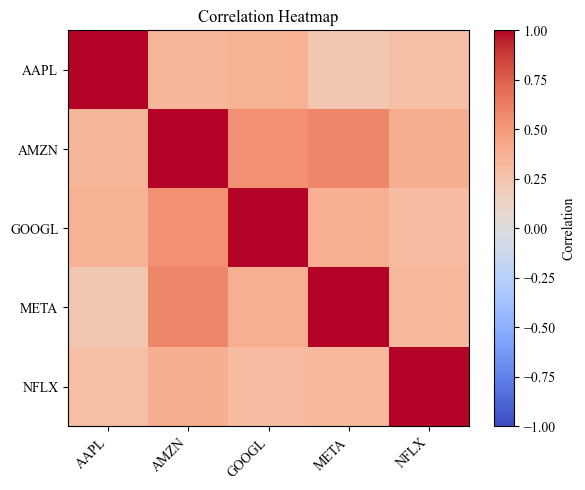

In [13]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 5))
plt.imshow(corr, aspect="auto", vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


## Animated Rolling Correlation Heatmap

This animation shows how the **pairwise correlations** between tickers evolve over time using a rolling window.

- **Window (`window`)**: number of trading days per correlation estimate (e.g., 60).
- **Color scale**: fixed to \([-1, 1]\) so colors are comparable across frames.
- **One plot per figure**: a single heatmap that updates each frame.



In [14]:
from matplotlib import animation

from data.fetch_data import load_prices
from matplotlib import rc
rc('animation', html='jshtml')  # tell matplotlib to render as JS/HTML
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import animation
from data.analytics import calculate_correlations 

rc("animation", html="jshtml")  # render as JS/HTML in VS Code/Jupyter

# ---- Config ----
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]
start = "2024-01-01"
end   = "2025-01-01"
window = 60           # rolling window length in trading days
interval_ms = 150     # animation speed (milliseconds between frames)

# ---- Data: prices -> returns handled INSIDE your helper ----
prices = load_prices(tickers, start=start, end=end, auto_adjust=True)



# Ensure we have enough rows for the first window
if len(prices) < window:
    raise ValueError(f"Not enough rows ({len(prices)}) for window={window}.")

# ---- Precompute rolling correlation matrices USING YOUR HELPER ----
dates = prices.index[window-1:]   # label each frame by the end-date of its window
corr_stack = []                   # list of (n x n) correlation matrices
cols = list(prices.columns)       # default labels (tickers); may expand if df_p is used

for i in range(window - 1, len(prices)):
    # Slice window [i-window+1, i]
    p_win = prices.iloc[i - window + 1 : i + 1]

    # Compute correlation via your helper.
    # If including portfolio correlation, use: C_df = calculate_correlations(p_win, df_portfolio=df_p)
    C_df = calculate_correlations(p_win)  
    # Capture columns on first iteration (in case helper adds "Portfolio")
    if i == window - 1:
        cols = list(C_df.columns)

    corr_stack.append(C_df.values)

corr_stack = np.stack(corr_stack, axis=0)  # shape: (T_frames, n, n)
n = len(cols)


# ---- Build animation ----
fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = ax.imshow(corr_stack[0], vmin=-1, vmax=1, aspect="auto", cmap="coolwarm")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Correlation", rotation=90)

# Ticks & labels
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_yticklabels(cols)
title = ax.set_title(f"Rolling {window}-Day Correlation — {dates[0].date()}")

plt.tight_layout()

def init():
    im.set_data(corr_stack[0])
    title.set_text(f"Rolling {window}-Day Correlation — {dates[0].date()}")
    return (im, title)

def update(frame_idx):
    im.set_data(corr_stack[frame_idx])
    title.set_text(f"Rolling {window}-Day Correlation — {dates[frame_idx].date()}")
    return (im, title)

anim = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=len(dates),
    interval=interval_ms,
    blit=True
)

# --- Display in Jupyter ---
import matplotlib.pyplot as plt
from IPython.display import display
plt.close(fig)   # avoid duplicate static image
display(anim)    # embedded, playable animation
